# 1. INSTALASI DAN IMPORT LIBRARY


In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import string
import json
import requests
from io import StringIO
import csv

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install Sastrawi

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

print("Semua library berhasil di-import.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Semua library berhasil di-import.


# 2. PERSIAPAN DATA DAN PREPROCESSING

In [43]:
# Load dataset hasil scraping
clean_df = pd.read_csv('ulasan_aplikasi_clean.csv')

# Cek 5 data teratas
clean_df.head()

,userName,content,score,at
0,Pengguna Google,"Gimana mau belanja, update terus, tapi buruk k...",1,2018-09-23 20:08:52
1,Pengguna Google,"pengiriman semakin gak jelas, sudah brp kali i...",1,2025-06-03 05:56:08
2,Pengguna Google,"lazada sekarang kok jadi nyebelin ,, bukannya ...",2,2025-06-03 07:26:21
3,Pengguna Google,menurut saya sih ya lazada ini bagus banyak di...,1,2025-06-02 22:09:34
4,Pengguna Google,tenyata banyak pedagang/ toko yg menjual baran...,4,2025-06-02 13:49:54


In [44]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39848 entries, 0 to 39847
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  39848 non-null  object
 1   content   39848 non-null  object
 2   score     39848 non-null  int64 
 3   at        39848 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [45]:
# Membuat file slang words eksternal

slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

# Menyimpan ke file JSON
with open('slang_words.json', 'w') as f:
    json.dump(slangwords, f)

# Memuat dari file JSON
with open('slang_words.json', 'r') as f:
    slangwords = json.load(f)

In [46]:
# Fungsi-fungsi Preprocessing

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Hapus mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Hapus hashtag
    text = re.sub(r'RT[\s]', '', text) # Hapus RT
    text = re.sub(r"http\S+", '', text) # Hapus link
    text = re.sub(r'[0-9]+', '', text) # Hapus angka
    text = text.replace('\n', ' ') # Ganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # Hapus tanda baca
    text = text.strip()
    return text

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return [word for word in text if word not in listStopwords and len(word) > 2]

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords.get(word, word) for word in words]
    return ' '.join(fixed_words)

def toSentence(list_words):
    return ' '.join(word for word in list_words)

In [47]:
clean_df

,userName,content,score,at
0,Pengguna Google,"Gimana mau belanja, update terus, tapi buruk k...",1,2018-09-23 20:08:52
1,Pengguna Google,"pengiriman semakin gak jelas, sudah brp kali i...",1,2025-06-03 05:56:08
2,Pengguna Google,"lazada sekarang kok jadi nyebelin ,, bukannya ...",2,2025-06-03 07:26:21
3,Pengguna Google,menurut saya sih ya lazada ini bagus banyak di...,1,2025-06-02 22:09:34
4,Pengguna Google,tenyata banyak pedagang/ toko yg menjual baran...,4,2025-06-02 13:49:54
...,...,...,...,...
39843,Pengguna Google,"Dulu prtama x blanja pernah dibuat kesel,karna...",1,2022-12-22 20:00:29
39844,Pengguna Google,aplikasi nya bagus tpi banyak seler yg kurang ...,5,2020-10-26 23:09:35
39845,Pengguna Google,"Maaf admin saya kasih bintang 1, soalnya saya ...",1,2022-02-28 09:58:06
39846,Pengguna Google,Maaf tapi ini aplikasinya Lemot Gambar tidak s...,2,2021-01-21 15:05:46


In [48]:
# Pipeline Preprocessing

print("\nMemulai proses preprocessing...")

clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefolding'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slang'] = clean_df['text_casefolding'].apply(fix_slangwords)
clean_df['text_tokenized'] = clean_df['text_slang'].apply(tokenizingText)
clean_df['text_filtered'] = clean_df['text_tokenized'].apply(filteringText)
clean_df['text_final'] = clean_df['text_filtered'].apply(toSentence)

print("Preprocessing selesai.")

display(clean_df[['content', 'text_final']].head())


Memulai proses preprocessing...
Preprocessing selesai.


,content,text_final
0,"Gimana mau belanja, update terus, tapi buruk k...",belanja update buruk kemajuannya aplikasi dibu...
1,"pengiriman semakin gak jelas, sudah brp kali i...",pengiriman kali estimasi pengiriman butuh rewa...
2,"lazada sekarang kok jadi nyebelin ,, bukannya ...",lazada nyebelin tingkatkan pelayanannya gratis...
3,menurut saya sih ya lazada ini bagus banyak di...,lazada bagus diskon promonya menarik sayang ke...
4,tenyata banyak pedagang/ toko yg menjual baran...,tenyata pedagang toko menjual barang kebanyaka...


# 3. PELABELAN (LABELING) DENGAN 3 KELAS

In [49]:
# Muat Lexicon
lexicon_positive = dict()
response_pos = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response_pos.status_code == 200:
    reader = csv.reader(StringIO(response_pos.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
response_neg = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response_neg.status_code == 200:
    reader = csv.reader(StringIO(response_neg.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

In [50]:
# Fungsi labeling dengan 3 kelas (positif, negatif, netral)
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    polarity = ''
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral' # Kelas Netral jika skor = 0
    return score, polarity

In [51]:
# Terapkan labeling

print("\nMelakukan pelabelan sentimen...")

results = clean_df['text_filtered'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]

print("Pelabelan selesai.")


Melakukan pelabelan sentimen...
Pelabelan selesai.


In [52]:
# Hapus data yang tidak memiliki teks setelah preprocessing
clean_df = clean_df[clean_df['text_final'] != '']

In [53]:
# Cek distribusi kelas
print("\nDistribusi Kelas Sentimen:")
print(clean_df['polarity'].value_counts())


Distribusi Kelas Sentimen:
polarity
positive    18997
negative    18531
neutral      2314
Name: count, dtype: int64


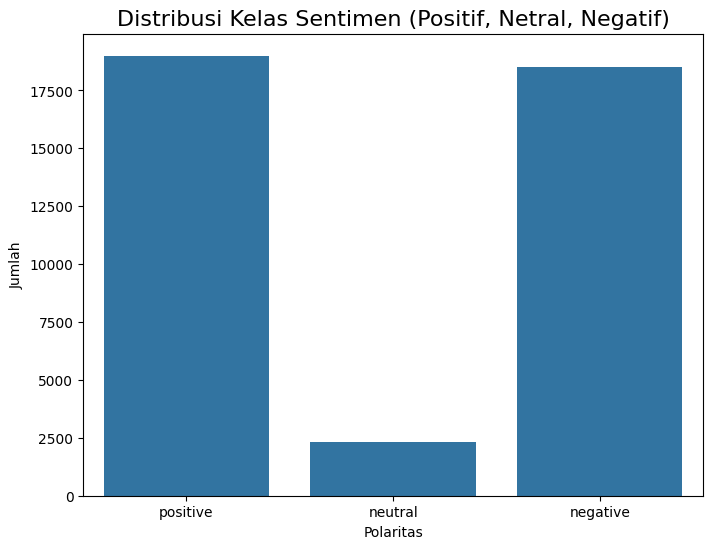

In [54]:
# Visualisasi distribusi kelas
plt.figure(figsize=(8, 6))
sns.countplot(x='polarity', data=clean_df, order=['positive', 'neutral', 'negative'])
plt.title('Distribusi Kelas Sentimen (Positif, Netral, Negatif)', fontsize=16)
plt.xlabel('Polaritas')
plt.ylabel('Jumlah')
plt.show()

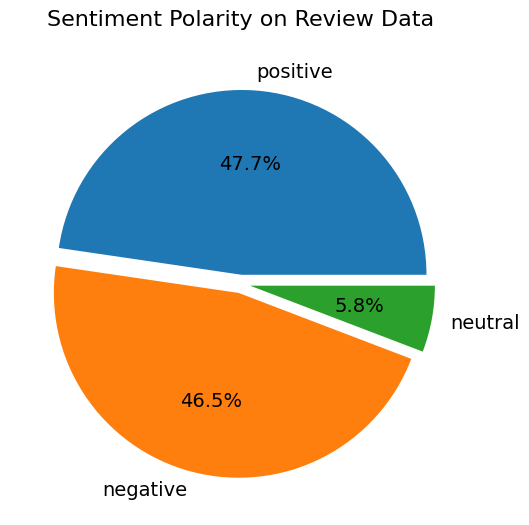

In [55]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in clean_df['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'labels'.
labels = list(clean_df['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = [0.05] * len(labels)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

# 4. VISUALISASI DATA (WORDCLOUD)

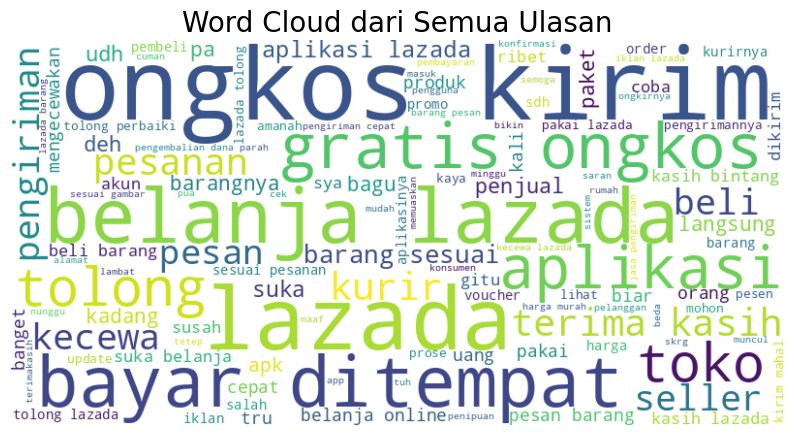

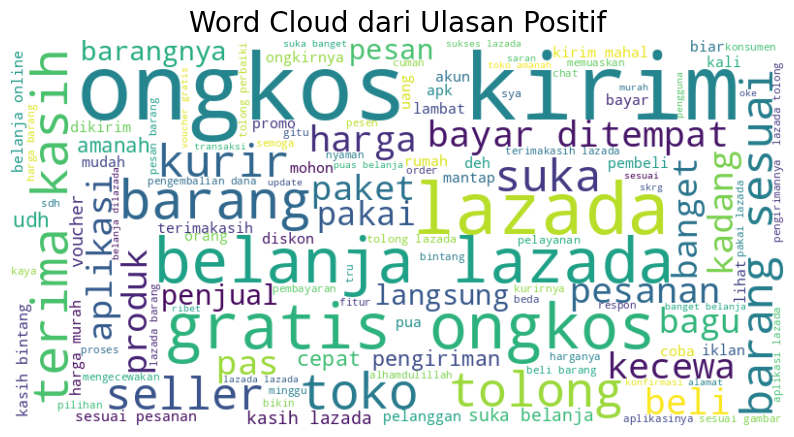

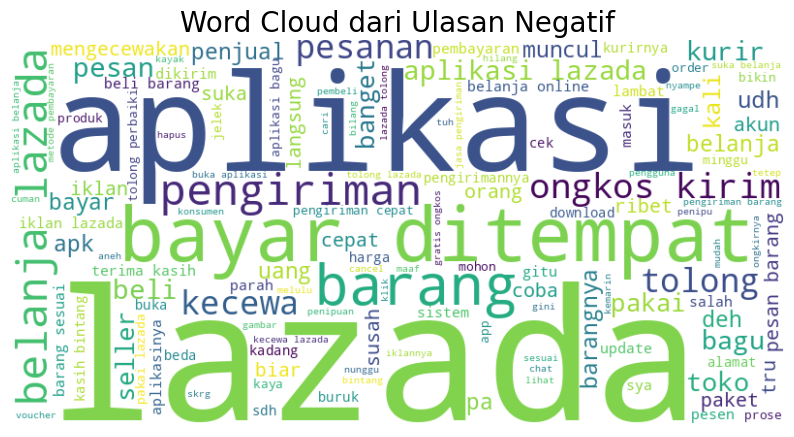

In [56]:
# Fungsi untuk membuat WordCloud (menghindari duplikasi)
def generate_wordcloud(data, title):
    all_words = ' '.join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='viridis', min_font_size=10).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Generate WordCloud untuk setiap sentimen
generate_wordcloud(clean_df['text_final'], 'Word Cloud dari Semua Ulasan')
generate_wordcloud(clean_df[clean_df['polarity'] == 'positive']['text_final'], 'Word Cloud dari Ulasan Positif')
generate_wordcloud(clean_df[clean_df['polarity'] == 'negative']['text_final'], 'Word Cloud dari Ulasan Negatif')

# 5. PERSIAPAN PEMODELAN

In [57]:
texts = clean_df['text_final'].astype(str)
labels = clean_df['polarity']

# Encode labels: positive=2, neutral=1, negative=0
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
print("\nMapping Label:", dict(zip(le.classes_, le.transform(le.classes_))))


Mapping Label: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


In [58]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(texts, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

print(f"\nUkuran data latih: {len(X_train)}")
print(f"Ukuran data uji: {len(X_test)}")


Ukuran data latih: 31873
Ukuran data uji: 7969


# 6. SKEMA 1: BIDIRECTIONAL LSTM


In [59]:
# Tokenisasi dan Padding
max_words = 10000
max_len = 120
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [60]:
# One-hot encode labels untuk 3 kelas
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [61]:
# Penanganan Imbalance Data dengan Class Weight
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights untuk LSTM:", class_weight_dict)

Class Weights untuk LSTM: {0: np.float64(0.7166498032602586), 1: np.float64(5.739780298937511), 2: np.float64(0.6991072799456033)}


In [62]:
# Bangun Model Bidirectional LSTM
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax') # 3 neuron untuk 3 kelas, softmax untuk klasifikasi multi-kelas
])

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model_lstm.fit(
    X_train_pad, y_train_cat,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.5852 - loss: 0.9039 - val_accuracy: 0.7984 - val_loss: 0.5309
Epoch 2/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8116 - loss: 0.5031 - val_accuracy: 0.7791 - val_loss: 0.4792
Epoch 3/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8602 - loss: 0.3775 - val_accuracy: 0.7784 - val_loss: 0.5089
Epoch 4/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9005 - loss: 0.2732 - val_accuracy: 0.8147 - val_loss: 0.4964
Epoch 5/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9177 - loss: 0.2351 - val_accuracy: 0.8530 - val_loss: 0.4349
Epoch 6/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9403 - loss: 0.1760 - val_accuracy: 0.8508 - val_loss: 0.4454
Epoch 7/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9593 - loss: 0.1301 - val_accuracy: 0.8552 - val_loss: 0.4680
Epoch 8/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9700 - loss: 0.0977 - 

In [64]:
# Evaluasi
train_loss, train_acc = model_lstm.evaluate(X_train_pad, y_train_cat, verbose=0)
test_loss, test_acc = model_lstm.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f"\nAkurasi Latih LSTM: {train_acc*100:.2f}%")
print(f"Akurasi Uji LSTM: {test_acc*100:.2f}%")


Akurasi Latih LSTM: 93.73%
Akurasi Uji LSTM: 85.51%


In [65]:
# Laporan Klasifikasi
y_pred_probs = model_lstm.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_probs, axis=1)
print("\nLaporan Klasifikasi LSTM:\n", classification_report(y_test, y_pred_lstm, target_names=le.classes_))

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Laporan Klasifikasi LSTM:
               precision    recall  f1-score   support

    negative       0.94      0.84      0.89      3706
     neutral       0.30      0.49      0.37       463
    positive       0.89      0.91      0.90      3800

    accuracy                           0.86      7969
   macro avg       0.71      0.75      0.72      7969
weighted avg       0.88      0.86      0.86      7969



# 7. SKEMA 2: NAIVE BAYES + TF-IDF + SMOTE


In [66]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [67]:
# Penanganan Imbalance dengan SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print("Distribusi kelas setelah SMOTE:", pd.Series(y_train_smote).value_counts())

Distribusi kelas setelah SMOTE: 0    15197
2    15197
1    15197
Name: count, dtype: int64


In [68]:
# Latih model Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_smote, y_train_smote)

MultinomialNB()

In [69]:
# Prediksi dan Evaluasi
y_pred_nb = nb_model.predict(X_test_tfidf)
print(f"\nAkurasi Uji Naive Bayes: {accuracy_score(y_test, y_pred_nb)*100:.2f}%")
print("\nLaporan Klasifikasi Naive Bayes:\n", classification_report(y_test, y_pred_nb, target_names=le.classes_))


Akurasi Uji Naive Bayes: 69.96%

Laporan Klasifikasi Naive Bayes:
               precision    recall  f1-score   support

    negative       0.76      0.73      0.75      3706
     neutral       0.13      0.29      0.18       463
    positive       0.80      0.72      0.76      3800

    accuracy                           0.70      7969
   macro avg       0.57      0.58      0.56      7969
weighted avg       0.74      0.70      0.72      7969



# 8. SKEMA 3: LOGISTIC REGRESSION + TF-IDF + SMOTE + GRIDSEARCHCV


In [70]:
# Model dan Parameter Grid
lr = LogisticRegression(random_state=42, max_iter=1000)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

In [71]:
# GridSearchCV untuk mencari parameter terbaik
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote) # Latih pada data hasil SMOTE

print("\nParameter terbaik ditemukan:", grid_search.best_params_)
best_lr_model = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Parameter terbaik ditemukan: {'C': 100, 'solver': 'liblinear'}


In [72]:
# Prediksi dan Evaluasi dengan model terbaik
y_pred_lr = best_lr_model.predict(X_test_tfidf)
print(f"\nAkurasi Uji Logistic Regression (terbaik): {accuracy_score(y_test, y_pred_lr)*100:.2f}%")
print("\nLaporan Klasifikasi Logistic Regression:\n", classification_report(y_test, y_pred_lr, target_names=le.classes_))


Akurasi Uji Logistic Regression (terbaik): 87.00%

Laporan Klasifikasi Logistic Regression:
               precision    recall  f1-score   support

    negative       0.91      0.90      0.90      3706
     neutral       0.30      0.35      0.32       463
    positive       0.91      0.91      0.91      3800

    accuracy                           0.87      7969
   macro avg       0.71      0.72      0.71      7969
weighted avg       0.87      0.87      0.87      7969



# 9. INFERENSI / PENGUJIAN MODEL


In [86]:
# Fungsi untuk Preprocessing Input Teks
def preprocess_text(text):
    cleaned_text = cleaningText(text)
    casefolded_text = casefoldingText(cleaned_text)
    slang_fixed_text = fix_slangwords(casefolded_text)
    tokenized_text = tokenizingText(slang_fixed_text)
    filtered_text = filteringText(tokenized_text)
    final_text = toSentence(filtered_text)
    return final_text

# --- Fungsi Prediksi LSTM ---
def predict_sentiment_lstm(text):
    processed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    prediction = model_lstm.predict(padded_sequence, verbose=0)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = le.inverse_transform([predicted_class_index])[0]
    return predicted_class_label, np.max(prediction)

# --- Fungsi Prediksi Model Machine Learning (Naive Bayes / LogReg) ---
def predict_sentiment_ml(text, model, vectorizer):
    processed_text = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)
    predicted_class_label = le.inverse_transform(prediction)[0]
    return predicted_class_label

# --- Pengujian Interaktif ---
print("\n--- Uji Coba Model dengan Input Baru ---")

# Contoh kalimat untuk diuji
test_sentences = [
    "aplikasinya keren banget, sangat bermanfaat dan mudah digunakan!", # Positif
    "payah, aplikasi ini sering macet dan tidak responsif. buang-buang waktu.", # Negatif
    "desainnya biasa saja, tapi bisa digunakan.", # Netral
    "belum mengalami kendala sejauh ini." # Netral
]

print("Menggunakan Model LSTM Terbaik:")
for sentence in test_sentences:
    prediction, confidence = predict_sentiment_lstm(sentence)
    print(f"Kalimat: '{sentence}'\nPrediksi: {prediction.upper()} (Confidence: {confidence:.2f})\n")

print("\n" + "="*50 + "\n")

print("Menggunakan Model Logistic Regression Terbaik:")
for sentence in test_sentences:
    prediction = predict_sentiment_ml(sentence, best_lr_model, tfidf)
    print(f"Kalimat: '{sentence}'\nPrediksi: {prediction.upper()}\n")

# --- Loop Interaktif ---
print("\n--- Coba Kalimat Anda Sendiri! (Ketik 'exit' untuk keluar) ---")
while True:
    user_input = input("Masukkan ulasan Anda: ")
    if user_input.lower() == 'exit':
        break

    # Pilih model mana yang ingin ditampilkan hasilnya
    pred_lstm, _ = predict_sentiment_lstm(user_input)
    pred_lr = predict_sentiment_ml(user_input, best_lr_model, tfidf)

    print(f"  -> Prediksi LSTM: {pred_lstm.upper()}")
    print(f"  -> Prediksi Logistic Regression: {pred_lr.upper()}")
    print("-" * 20)


--- Uji Coba Model dengan Input Baru ---
Menggunakan Model LSTM Terbaik:
Kalimat: 'aplikasinya keren banget, sangat bermanfaat dan mudah digunakan!'
Prediksi: POSITIVE (Confidence: 1.00)

Kalimat: 'payah, aplikasi ini sering macet dan tidak responsif. buang-buang waktu.'
Prediksi: NEGATIVE (Confidence: 1.00)

Kalimat: 'desainnya biasa saja, tapi bisa digunakan.'
Prediksi: NEUTRAL (Confidence: 0.99)

Kalimat: 'belum mengalami kendala sejauh ini.'
Prediksi: NEUTRAL (Confidence: 0.99)



Menggunakan Model Logistic Regression Terbaik:
Kalimat: 'aplikasinya keren banget, sangat bermanfaat dan mudah digunakan!'
Prediksi: POSITIVE

Kalimat: 'payah, aplikasi ini sering macet dan tidak responsif. buang-buang waktu.'
Prediksi: NEGATIVE

Kalimat: 'desainnya biasa saja, tapi bisa digunakan.'
Prediksi: NEUTRAL

Kalimat: 'belum mengalami kendala sejauh ini.'
Prediksi: NEUTRAL


--- Coba Kalimat Anda Sendiri! (Ketik 'exit' untuk keluar) ---
Masukkan ulasan Anda: barang yang dikirim beda sama yang di